# Part One: Training Phase

In this part we prepare the dataset and train our models with Three approaches and save the trained models then we analyze the results.

In [1]:
import random
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
directory = '/kaggle/input/sadaf-hda-dataset/sadaf-hda-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
batch_size = 32
img_height = 256
img_width = 256
NUM_CHANNELS = 3

Here we implemented some data preprocessing and data augmentation techniques such as rescaling, zero padding and cropping.

In [3]:
def resize_with_crop_or_pad(image, label):
    return tf.image.resize_with_crop_or_pad(image, img_height, img_width), label

# def clahe_like(image, label):
#     return tf.image.adjust_contrast(image, 1.5), label

def resize(image, label):
    return tf.image.resize(image, [img_height, img_width]), label

def normalizer(image, label):
    return tf.cast(image, tf.float32) / 255., label

Then we create train and test dataset objects with map, cache and prefetch techniques.

In [4]:
def create_dataset(directory, batch_size):
    train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset='training',
        crop_to_aspect_ratio=False)

    test_dataset = tf.keras.utils.image_dataset_from_directory(directory,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb',
      batch_size=batch_size,
      seed=42,
      validation_split=0.2,
      subset='validation',
      crop_to_aspect_ratio=False)

    train_dataset = train_dataset.map(resize_with_crop_or_pad, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     train_dataset = train_dataset.map(clahe_like, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.map(normalizer, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.cache('training set')
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    test_dataset = test_dataset.map(resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(normalizer, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.cache('test set')
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_dataset, test_dataset

In [5]:
train_dataset, test_dataset = create_dataset(directory, batch_size)

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Found 4575 files belonging to 3 classes.
Using 915 files for validation.


This function plot some of images and labels.

In [6]:
def plot_image(X_input, labels):
    plt.imshow(X_input, cmap=plt.cm.gray_r, interpolation='nearest')
    print("LABEL: %s" % labels)
    plt.show()
    return

def label_decoder(label):
    if label[0] == 1:
        return 'Covid'
    if label[1] == 1:
        return 'Normal'
    if label[2] == 1:
        return 'Pneumonia'

LABEL: Normal


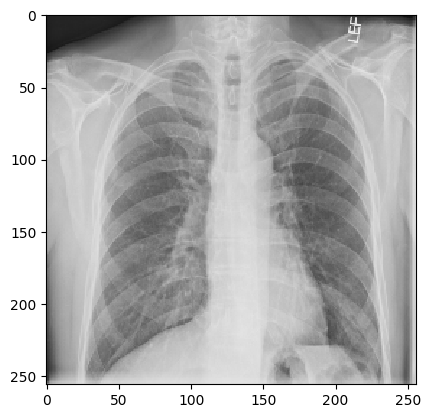

LABEL: Pneumonia


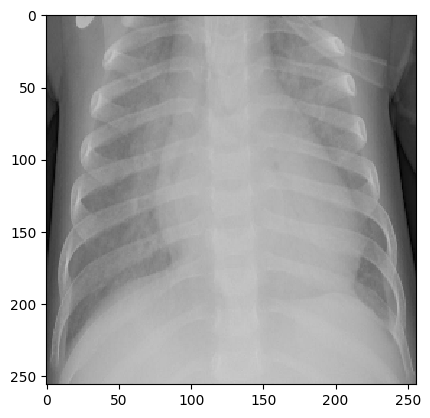

LABEL: Covid


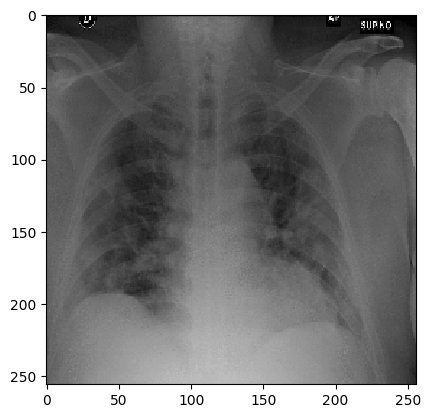

LABEL: Pneumonia


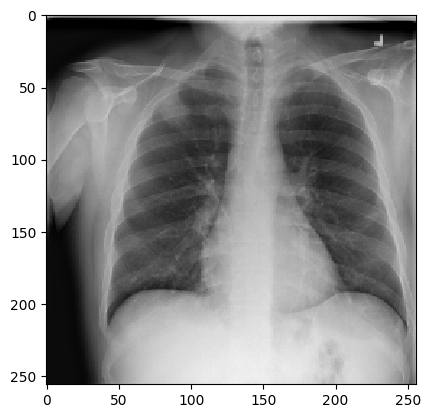

LABEL: Covid


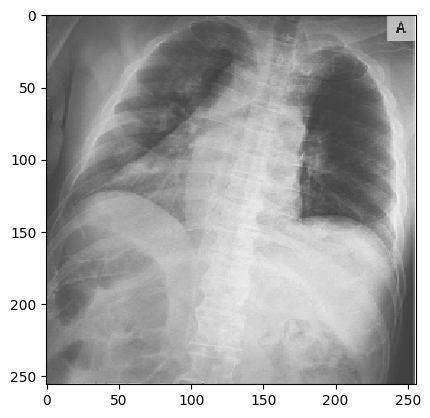

In [7]:
indices = np.random.randint(0, 32, (5,))
ds = train_dataset.take(1).get_single_element()
for index in indices:
    image = ds[0][index]
    label = label_decoder(ds[1][index])
    plot_image(image, label)

LABEL: Pneumonia


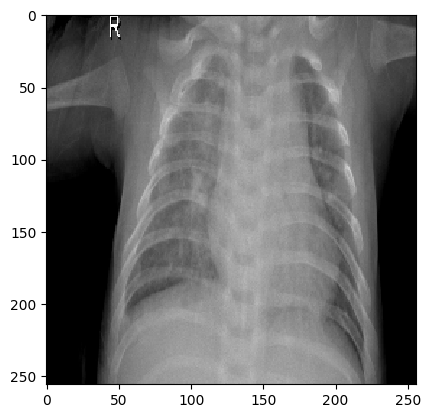

LABEL: Pneumonia


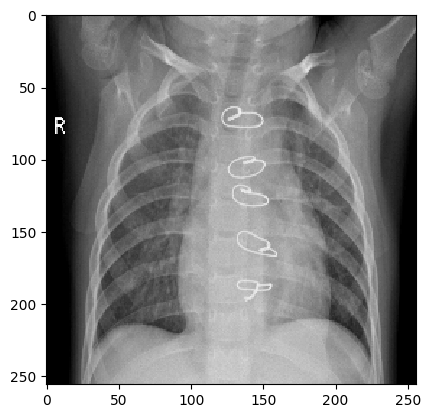

LABEL: Covid


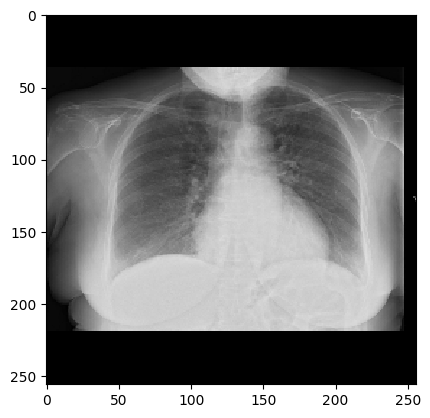

LABEL: Pneumonia


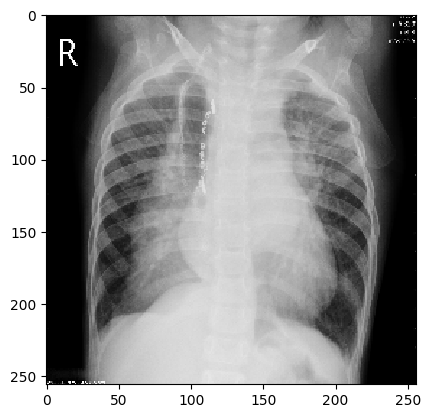

LABEL: Covid


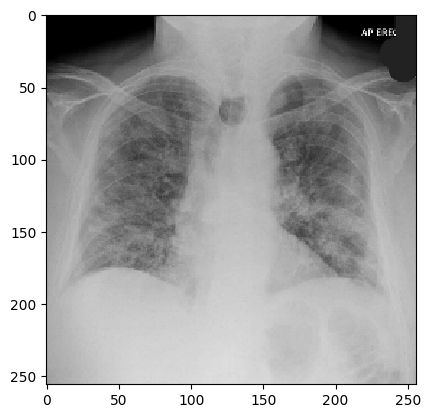

In [8]:
indices = np.random.randint(0, 32, (5,))
ds = test_dataset.take(1).get_single_element()
for index in indices:
    image = ds[0][index]
    label = label_decoder(ds[1][index])
    plot_image(image, label)

And here we defined train and validation steps and some functions to handle plotting the curves, saving histories and calculating some metrics for evaluation.

In [9]:
train_steps = int(tf.data.experimental.cardinality(train_dataset).numpy())

test_steps = int(tf.data.experimental.cardinality(test_dataset).numpy())

In [10]:
def plot_loss_acc(history, save=True):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()
    return

In [11]:
def plot_confusion_matrix(model):
    classes=['covid', 'normal', 'pneumonia']
    y_test_preds = model.predict(test_dataset)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in test_dataset], axis=0)
    y_test = y_test.argmax(axis=1)
    cm = confusion_matrix(y_test, y_test_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.rcParams['font.size'] = '14'
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

In [12]:
 class EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor, threshold, max_epochs, patience=3):
        super(EarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.best_weights = None
        self.max_epochs = max_epochs
        self.best_monitoring_value = float('-inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_monitoring_value = logs.get(self.monitor)
        if current_monitoring_value is None:
            raise ValueError(f"The metric {self.monitor} is not available in logs for early stopping.")
        if epoch >= self.max_epochs - 1:
            print(f"\n--- Early stopping: Reached maximum number of epochs : {self.max_epochs} \n")
            self.model.set_weights(self.best_weights)
            self.model.stop_training = True
            return
        if current_monitoring_value > self.best_monitoring_value:
            self.best_weights = self.model.get_weights()
            self.best_monitoring_value = current_monitoring_value
        if current_monitoring_value < self.threshold:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True
                print(f"\n--- Early stopping: {self.monitor} has been more than {self.threshold} for {self.patience} epochs.\n")
                return

# CustomCNN model

In [13]:
class CustomCNN:

    def __CustomCNN(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=x, name='CustomCNN')
    
    def create_model(self, input_shape, num_classes):
        base_model = self.__CustomCNN(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(512, activation='relu')(fc)
        fc = tf.keras.layers.Dropout(0.3)(fc)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='CustomCNN-Classifier')

In [14]:
customcnn = CustomCNN().create_model(input_shape=(img_height, img_width, NUM_CHANNELS), num_classes=3)

In [15]:
customcnn.summary()

Model: "CustomCNN-Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125,

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_customcnn.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 80

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.91, max_epochs=MAX_EPOCHS, patience=5)

customcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [17]:
customcnn_history = customcnn.fit(train_dataset, epochs = MAX_EPOCHS, validation_data=test_dataset, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/80
115/115 [==============================] - ETA: 0s - loss: 0.7943 - accuracy: 0.7096 - precision: 0.7283 - recall: 0.6855
Epoch 1: val_accuracy improved from -inf to 0.35191, saving model to best_customcnn.h5
115/115 [==============================] - 77s 544ms/step - loss: 0.7943 - accuracy: 0.7096 - precision: 0.7283 - recall: 0.6855 - val_loss: 1.0501 - val_accuracy: 0.3519 - val_precision: 0.7982 - val_recall: 0.0995
Epoch 2/80
114/115 [============================>.] - ETA: 0s - loss: 0.4971 - accuracy: 0.8344 - precision: 0.8447 - recall: 0.8183
Epoch 2: val_accuracy improved from 0.35191 to 0.58361, saving model to best_customcnn.h5
115/115 [==============================] - 16s 135ms/step - loss: 0.4986 - accuracy: 0.8339 - precision: 0.8440 - recall: 0.8178 - val_loss: 0.9233 - val_accuracy: 0.5836 - val_precision: 0.6797 - val_recall: 0.3410
Epoch 3/80
114/115 [============================>.] - ETA: 0s - loss: 0.4177 - accuracy: 0.8627 - precision: 0.8725 - recall:

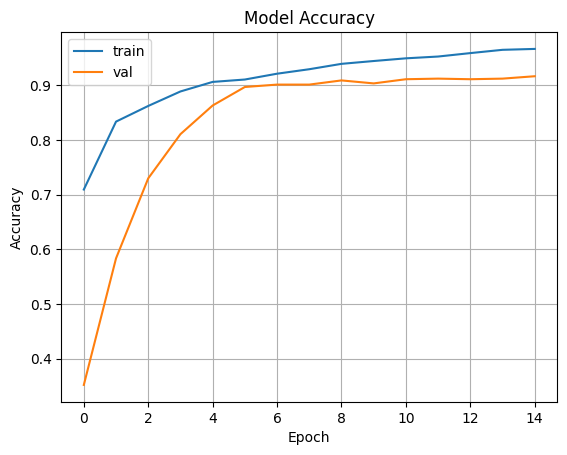

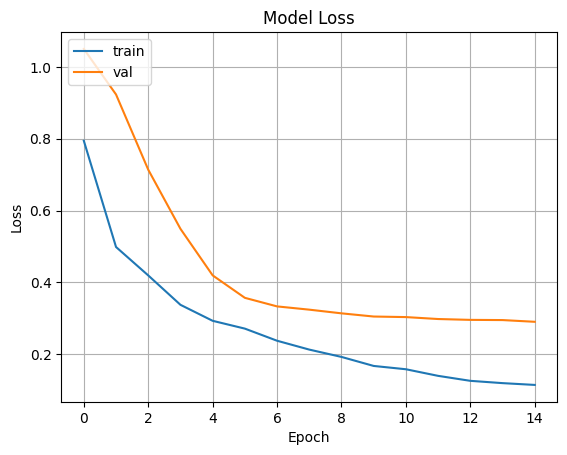

In [18]:
plot_loss_acc(customcnn_history)

In [19]:
customcnn_score = customcnn.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("CustomCNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(customcnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(customcnn_score[1]))
print('Testset Precision = {:.2f}'.format(customcnn_score[2]))
print('Testset Recall = {:.2f}'.format(customcnn_score[3]))

29/29 [==============================] - 1s 24ms/step - loss: 0.2903 - accuracy: 0.9169 - precision: 0.9215 - recall: 0.9115
CustomCNN classifier evaluation results:

Testset Loss = 0.29032
Testset Accuracy = 0.92
Testset Precision = 0.92
Testset Recall = 0.91


29/29 [==============================] - 1s 23ms/step


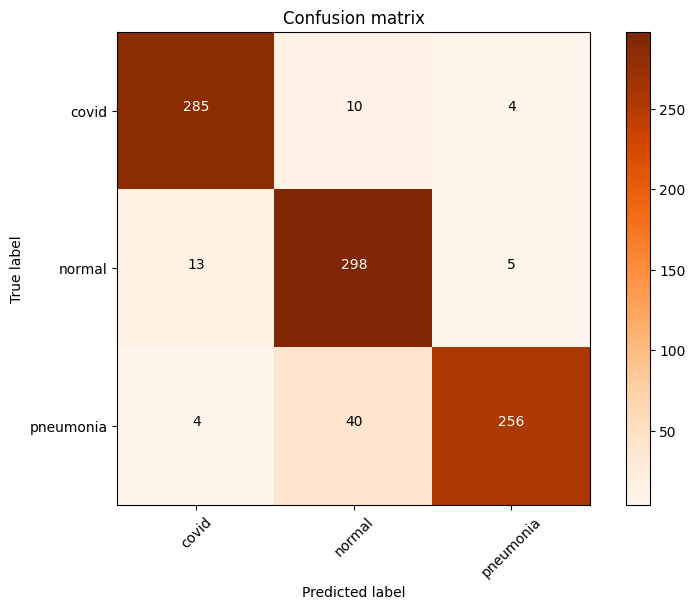

In [20]:
plot_confusion_matrix(customcnn)

# InceptionV4 model

In [13]:
class InceptionV4:
        
    def __conv2d_with_batch(self, prev_layer, nbr_kernels, filter_size, strides=(1, 1), padding='valid'):
        X = tf.keras.layers.Conv2D(filters=nbr_kernels, kernel_size=filter_size, strides=strides, padding=padding)(prev_layer)
        X = tf.keras.layers.BatchNormalization()(X)
        return tf.keras.layers.Activation(activation='relu')(X)
    

    def __stem_block(self, prev_layer):
        X = self.__conv2d_with_batch(prev_layer, nbr_kernels=32, filter_size=(3, 3), strides=(2, 2))
        X = self.__conv2d_with_batch(X, nbr_kernels=32, filter_size=(3, 3))
        X = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(3, 3))
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(3, 3), strides=(2, 2))
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=96, filter_size=(3, 3))
        X_2 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(X_2, nbr_kernels=96, filter_size=(3, 3))
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=192, filter_size=(3, 3), strides=2)
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        return tf.keras.layers.concatenate([X_1, X_2], axis=3)
    

    def __reduction_A_block(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(3, 3), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 3), strides=(2, 2))
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(3, 3), strides=(2, 2))
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    

    def __reduction_B_block(self, prev_layer):
        X_1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=192, filter_size=(3, 3), strides=(2, 2))
        X_3 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(7, 1), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(3, 3), strides=(2, 2))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    

    def __inception_block_A(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=96, filter_size=(3, 3), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=96, filter_size=(1, 1), padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=96, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_B(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=192, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(7, 1), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=128, filter_size=(1, 1))
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_C(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=448, filter_size=(3, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=512, filter_size=(1, 3), padding='same')
        X_1_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_1_2 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_1 = tf.keras.layers.concatenate([X_1_1, X_1_2], axis=3)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_2_1 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_2_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_2 = tf.keras.layers.concatenate([X_2_1, X_2_2], axis=3)
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=3, padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)
    

    def __InceptionV4(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)
        
        X = self.__stem_block(prev_layer=input_layer)
        
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        
        X = self.__reduction_A_block(prev_layer=X)
        
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        
        X = self.__reduction_B_block(prev_layer=X)
        
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        
        output = tf.keras.layers.GlobalAveragePooling2D()(X)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=output, name='InceptionV4')

    def create_model(self, input_shape, num_classes):
        base_model = self.__InceptionV4(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dropout(rate=0.2)(fc)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='InceptionV4_Classifier')

In [14]:
inceptionv4 = InceptionV4().create_model(input_shape=(img_height, img_width, NUM_CHANNELS), num_classes=3)

In [15]:
inceptionv4.summary()

Model: "InceptionV4_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                            

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_inceptionv4.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 80

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.85, max_epochs=MAX_EPOCHS, patience=5)

inceptionv4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [17]:
inceptionv4_history = inceptionv4.fit(train_dataset, epochs = MAX_EPOCHS, validation_data=test_dataset, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/80
115/115 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.7074 - precision: 0.7678 - recall: 0.6235
Epoch 1: val_accuracy improved from -inf to 0.32787, saving model to best_inceptionv4.h5
115/115 [==============================] - 206s 752ms/step - loss: 0.7235 - accuracy: 0.7074 - precision: 0.7678 - recall: 0.6235 - val_loss: 1.3034 - val_accuracy: 0.3279 - val_precision: 0.3279 - val_recall: 0.3279
Epoch 2/80
115/115 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.8410 - precision: 0.8481 - recall: 0.8251
Epoch 2: val_accuracy improved from 0.32787 to 0.34536, saving model to best_inceptionv4.h5
115/115 [==============================] - 52s 454ms/step - loss: 0.4595 - accuracy: 0.8410 - precision: 0.8481 - recall: 0.8251 - val_loss: 1.1793 - val_accuracy: 0.3454 - val_precision: 0.4033 - val_recall: 0.1869
Epoch 3/80
115/115 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8784 - precision: 0.8869 - re

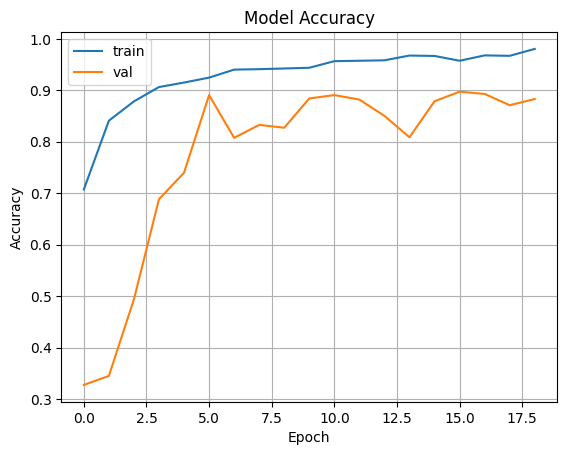

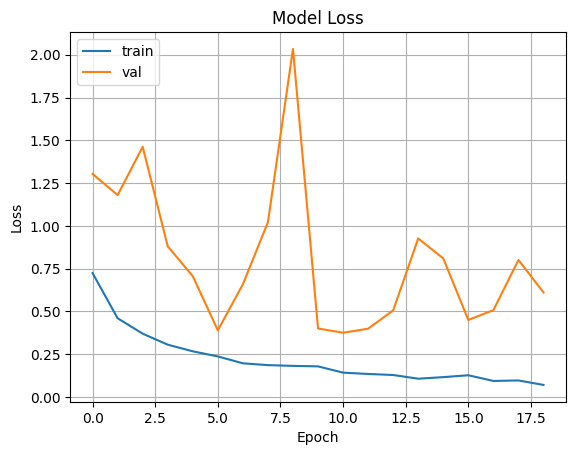

In [18]:
plot_loss_acc(inceptionv4_history)

In [19]:
inceptionv4_score = inceptionv4.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("InceptionV4 classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(inceptionv4_score[0]))
print('Testset Accuracy = {:.2f}'.format(inceptionv4_score[1]))
print('Testset Precision = {:.2f}'.format(inceptionv4_score[2]))
print('Testset Recall = {:.2f}'.format(inceptionv4_score[3]))

29/29 [==============================] - 4s 121ms/step - loss: 0.4496 - accuracy: 0.8973 - precision: 0.8989 - recall: 0.8940
InceptionV4 classifier evaluation results:

Testset Loss = 0.44960
Testset Accuracy = 0.90
Testset Precision = 0.90
Testset Recall = 0.89


29/29 [==============================] - 6s 117ms/step


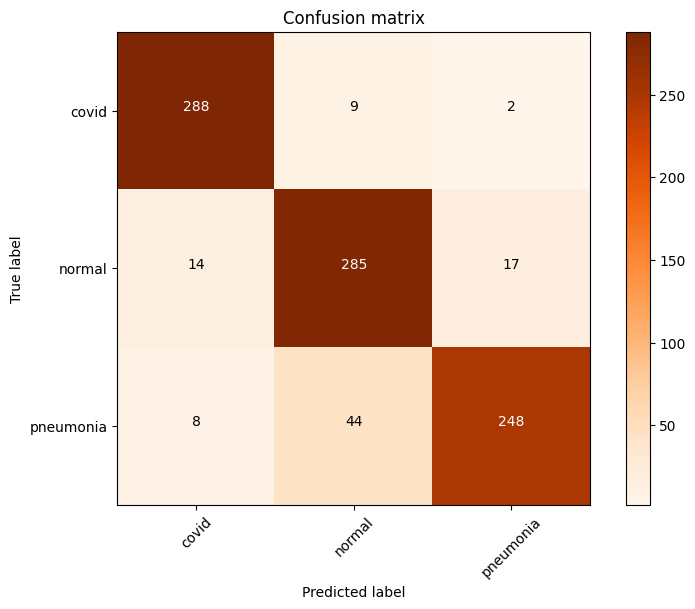

In [20]:
plot_confusion_matrix(inceptionv4)

# DensNet model 

In [21]:
class DenseNet121:
    def __conv_block(self, x, growth_rate):
        x1 = tf.keras.layers.BatchNormalization()(x)
        x1 = tf.keras.layers.Activation('relu')(x1)
        x1 = tf.keras.layers.Conv2D(growth_rate, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x1)
        return tf.keras.layers.concatenate([x, x1], axis=-1)
    
    def __dense_block(self, x, blocks, growth_rate):
        for _ in range(blocks):
            x = self.__conv_block(x, growth_rate)
        return x
    
    def __transition_block(self, x, reduction):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x)
        return tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    
    def __DenseNet121(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = self.__dense_block(x, 6, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 12, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 24, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 16, 32)

        output = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=output, name='DenseNet121')

    def create_model(self, input_shape, num_classes):
        base_model = self.__DenseNet121(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
#         fc = tf.keras.layers.Dropout(rate=0.4)(fc)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='DenseNet121_Classifier')

In [22]:
densenet121 = DenseNet121().create_model(input_shape=(img_height, img_width, NUM_CHANNELS), num_classes=3)

In [23]:
densenet121.summary()

Model: "DenseNet121_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 128, 128, 64  256        ['conv2d_4[0][0]']               
 rmalization)                   )                                            

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_densenet121.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 80

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.90, max_epochs=MAX_EPOCHS, patience=5)

densenet121.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
densenet121_history = densenet121.fit(train_dataset, epochs = MAX_EPOCHS, validation_data=test_dataset, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/80
115/115 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.7751 - precision_1: 0.8360 - recall_1: 0.7049
Epoch 1: val_accuracy improved from -inf to 0.36612, saving model to best_densenet121.h5
115/115 [==============================] - 84s 281ms/step - loss: 1.1481 - accuracy: 0.7751 - precision_1: 0.8360 - recall_1: 0.7049 - val_loss: 1.6597 - val_accuracy: 0.3661 - val_precision_1: 0.5082 - val_recall_1: 0.2022
Epoch 2/80
115/115 [==============================] - ETA: 0s - loss: 0.8955 - accuracy: 0.8997 - precision_1: 0.9098 - recall_1: 0.8822
Epoch 2: val_accuracy improved from 0.36612 to 0.49508, saving model to best_densenet121.h5
115/115 [==============================] - 25s 217ms/step - loss: 0.8955 - accuracy: 0.8997 - precision_1: 0.9098 - recall_1: 0.8822 - val_loss: 1.6856 - val_accuracy: 0.4951 - val_precision_1: 0.5382 - val_recall_1: 0.3923
Epoch 3/80
115/115 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.9230 -

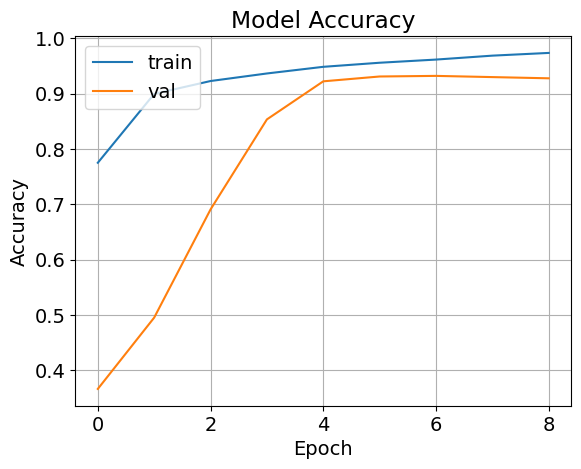

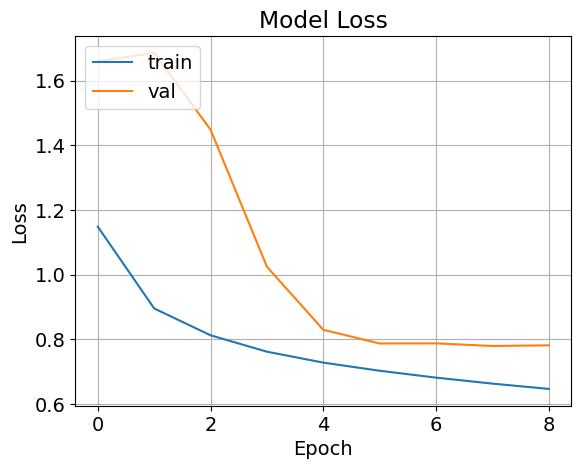

In [26]:
plot_loss_acc(densenet121_history)

In [27]:
densenet121_score = densenet121.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("DenseNet121 classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(densenet121_score[0]))
print('Testset Accuracy = {:.2f}'.format(densenet121_score[1]))
print('Testset Precision = {:.2f}'.format(densenet121_score[2]))
print('Testset Recall = {:.2f}'.format(densenet121_score[3]))

29/29 [==============================] - 2s 65ms/step - loss: 0.7875 - accuracy: 0.9322 - precision_1: 0.9332 - recall_1: 0.9311
DenseNet121 classifier evaluation results:

Testset Loss = 0.78751
Testset Accuracy = 0.93
Testset Precision = 0.93
Testset Recall = 0.93


29/29 [==============================] - 3s 60ms/step


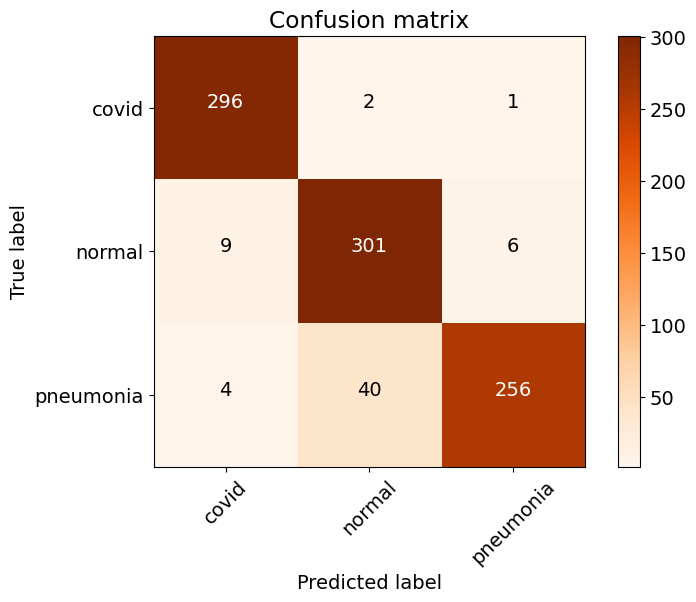

In [28]:
plot_confusion_matrix(densenet121)